# 3D structure tensor - a small example

*Author: Vedrana Andersen Dahl (vand@dtu.dk), uses code by Niels Jeppesen*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vedranaa/teaching-notebooks/blob/main/Orientations_Small_3D_example.ipynb)

A small example demonstrating the use of 3D structure tensor for visualizing and clustering dominant orientation. 
We use the structure tensor implementation provided by [structure-tensor package](https://github.com/Skielex/structure-tensor). We also use [scmap module](https://github.com/vedranaa/sphere-colormap) for sperical colormap. And lastly we use small module [volvisplotyly](https://github.com/vedranaa/goodies/blob/main/volvizplotly.py) for easier 3D visualization in ploty.

In [1]:
# Install custom-made packages and get the data.
!pip install -q structure_tensor
!pip install -q scmap
!wget 'https://qim.compute.dtu.dk/data-repository/demo_data/multicube.tif' -q
!wget 'https://raw.githubusercontent.com/vedranaa/goodies/main/volvizplotly.py' -q

In [2]:
# Import commonly used packages
import numpy as np
import matplotlib.pyplot as plt
import tifffile

# Import custom-made packages
import structure_tensor as st
import scmap
from volvizplotly import volume_slicer


## Reading the data

The data is a small cube from a volumetric image og fibre composite. The cube contains five bundles in layers: UD fibre (0 deg), crossing fibre (45 deg), 90 deg fibre, -45 deg bundle, UD bundle (0 deg).

Volume shape is: (150, 150, 150)
Volume data type is: uint8
Intensity range is: 025-223


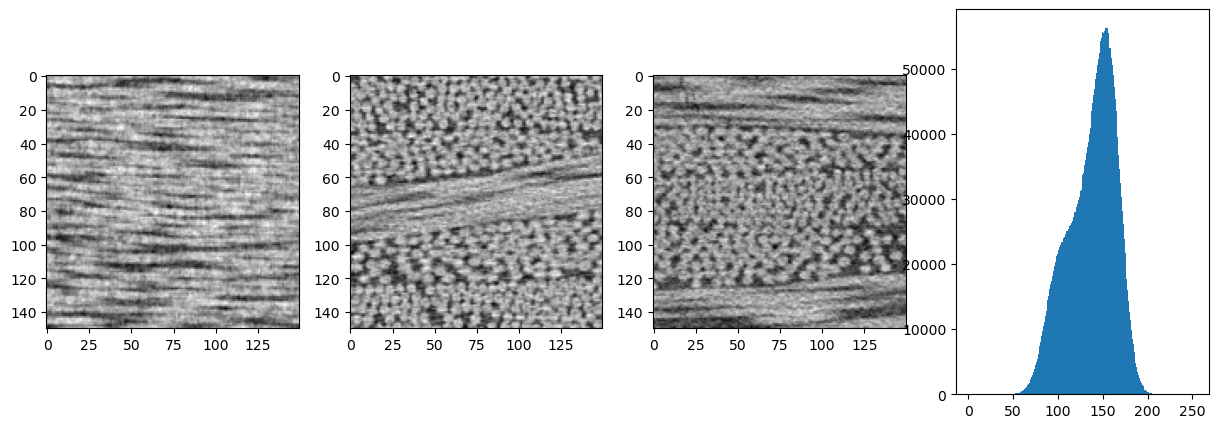

In [3]:
vol = tifffile.imread('multicube.tif')
# Transpose (rotate), just for better illustration
vol = np.transpose(vol, (1, 0, 2))

print(f'Volume shape is: {vol.shape}')
print(f'Volume data type is: {vol.dtype}')
print(f'Intensity range is: {vol.min():03}-{vol.max()}')

# Visualize volume slices and histogram
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(vol[vol.shape[0]//2], cmap=plt.cm.gray)
ax[1].imshow(vol[:, vol.shape[1]//2, :], cmap=plt.cm.gray)
ax[2].imshow(vol[:, :, vol.shape[2]//2], cmap=plt.cm.gray)
ax[3].hist(vol.ravel(), np.arange(257)-0.5)
plt.show()

We visualize the orthogonal cross sections and the surface of 3D volume in plotly.

In [ ]:
volume_slicer(vol, ['mid', 'mid', 'mid'])

In [ ]:
volume_slicer(vol, ['ends', 'ends', 'ends'])

## Computing the structure tensor and the dominant orientation
Computation of structure tensor requires only two parameters: the noise scale sigma and the integration scale rho. Parameter sigma controls smothing while computing gradientes, and structures smaller than sigma will be removed by smoothing. Parameter rho gives the size over the neighborhood in which the orientation is to be analysed for every volume voxel. Larger rho will result in a smoother orientation field.

Structure tensor is a 3x3 matrix, but as it is symmetrical we only carry values of 6 elements: $s_{xx}$, $s_{yy}$, $s_{zz}$, $s_{xy}$, $s_{xz}$ and $s_{yz}$.

Eigenvalues (val) carry the information about the degree of anisotropy - this is not used or visualized here. Eigenvectors (vec) carry the orientation information, as $x$, $y$, and $z$ component of the orientation vector.

In [6]:
# Change data type to double
vol = vol.astype(float)/255

In [7]:
sigma = 0.5 # noise scale
rho = 2 # integration scale
S = st.structure_tensor_3d(vol, sigma, rho)
val, vec = st.eig_special_3d(S)

print(f'The volume has a shape {vol.shape}, i.e. {vol.size} voxels.')
print(f'Structure tensor information is carried in a {S.shape} array.')
print(f'Orientation information is carried in a {vec.shape} array.')

The volume has a shape (150, 150, 150), i.e. 3375000 voxels.
Structure tensor information is carried in a (6, 150, 150, 150) array.
Orientation information is carried in a (3, 150, 150, 150) array.


Visualizing subset of dominant orientetions as points on a unit sphere.

In [ ]:
import plotly.graph_objects as go

N = 1000
random_sample = np.random.choice(vol.size, size=N, replace=False)

x = vec[0].ravel()[random_sample]
y = vec[1].ravel()[random_sample]
z = vec[2].ravel()[random_sample]
x = np.array([x, -x]).ravel()
y = np.array([y, -y]).ravel()
z = np.array([z, -z]).ravel()

vectors = np.stack((x, y, z), axis=1)
coloring = scmap.Duo()
rgb = coloring(vectors)

scatter = [go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=rgb))]
scene = dict(xaxis = dict(range=[-1, 1], autorange=False),
            yaxis = dict(range=[-1, 1], autorange=False),
            zaxis = dict(range=[-1, 1], autorange=False), 
            aspectratio = dict(x=1, y=1, z=1))
layout = dict(width=600, height=600, scene=scene)

fig = go.Figure(data=scatter, layout=layout)
fig.show()

## Visualizing the dominant orientation
Here we show only dominant orientation, ignoring shape measures. 

Since slicng is in $z$ direction, the arrows show $x$ and $y$ component of orientation vectors, on top of every slice.

In [9]:
def show_vol_flow(V, vec, z, s=5, double_arrow = False, ax=None):     
    xmesh, ymesh = np.mgrid[0:V.shape[1], 0:V.shape[2]]
    if ax is None:
      fig, ax = plt.subplots()
    ax.imshow(V[z], cmap=plt.cm.gray)
    g = slice(s//2, None, s)
    ax.quiver(ymesh[g, g], xmesh[g, g], vec[0, z, g, g], vec[1, z, g, g],
              color='r', angles='xy')
    if double_arrow:
        ax.quiver(ymesh[g, g], xmesh[g, g], -vec[0, z, g, g], -vec[1, z, g, g],
              color='r', angles='xy')
    ax.set_title(f'slice z={z}')


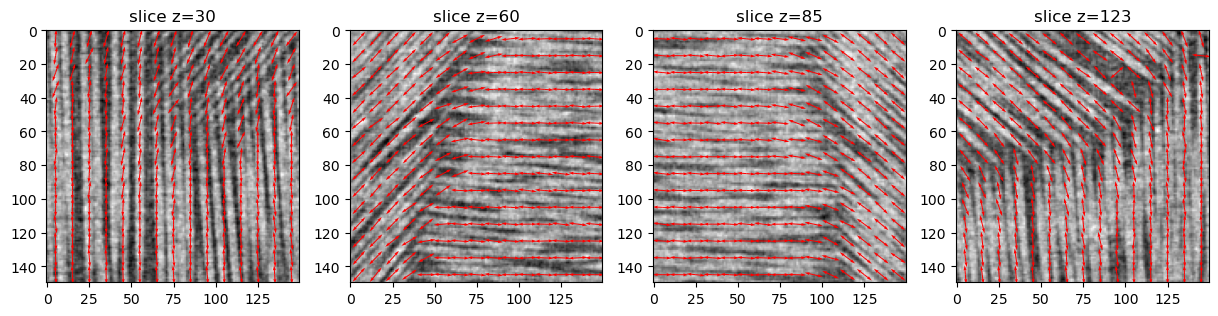

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for z, a in zip([30, 60, 85, 123], ax):
  show_vol_flow(vol, vec, z=z, s=10, double_arrow = True, ax=a) 
plt.show()

When visualizing the orientation as color, I choose fan coloring (`Duo` in `scmap`) which uses hsv colors for orientatins in a certain plane, here a $xy$ plane, and gray color for the orientations orthogonal to this plane. This coloring is convenient since all fibre bundles lay in $xy$ plane.

In [17]:
def show_vol_orientation(V, vec, z, coloring = scmap.Duo(), alpha=0.5, ax=None):

    dim = V.shape[1:]
    vectors = vec[:,z].transpose((1,2,0)).reshape(-1, 3)
    rgb = coloring(vectors).reshape(dim + (3,))
    rgba = np.concatenate((rgb, alpha*np.ones(dim + (1,))), axis=2)
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(V[z], cmap=plt.cm.gray)
    ax.imshow(rgba)
    ax.set_title(f'slice z={z}')


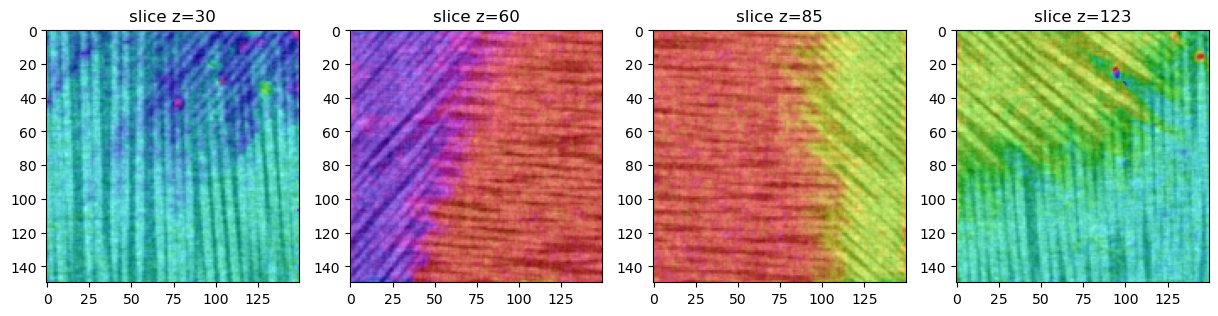

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for z, a in zip([30, 60, 85, 123], ax):
  show_vol_orientation(vol, vec, z=z, ax=a)
plt.show()

# The part of the notebook starting here is in development
Code needs to be modified 
- to use scmap for visualization
- to avoid reshape

In [ ]:
# TODO use scmap instead
azimuth = np.arctan(vec[1]/vec[0]) % np.pi
volume_slicer(azimuth, ['mid', 'mid', 'mid'], cmin=0, cmax=np.pi, colorscale='HSV')

In [ ]:
# TODO crop volume a few slices
volume_slicer(azimuth, [[4, 145], [4, 145], [4, 145]], cmin=0, cmax=np.pi, colorscale='HSV')

## Investigating tensor-vector distance
A tensor-vector distance can be computed for every voxel. Here I compute the distance from the x-direction. The the middle layer is aligned with x-direction, and has the smallest distance.

In [ ]:
def tensor_vector_distance(S, u):
    """ Caclulating pairwise distance between tensors and vectors
    Arguments:
        S: an array with shape (6, N) containing tensor
        v: an array with shape (M, 3) containing vectors
    Returns:
        v: an array with shape (N, M) containing pairwise distances
    Author: vand@dtu.dk, 2019
    """
    dist = np.dot(S[0:3].T, u**2) + 2*np.dot(S[3:].T, u[[0, 0, 1]] * u[[1, 2, 2]])
    return dist

u = np.array([1, 0, 0])
dist = tensor_vector_distance(S.reshape((6, -1)), u).reshape(S.shape[1:])
volume_slicer(dist, ['mid', 'mid', 'mid'], cmin=0, cmax=0.005)


In [ ]:
t = np.sqrt(1/2)
u_clusters = np.array([[1, 0, 0], [0, 1, 0], [t, t, 0], [t, -t, 0]]).T # initalizing orientations close to desired solution   

def cluster_tensors(S, u_clusters, nr_iters = 10):
    """ Clusters tensors with k-means initialized at vectors
    Arguments:
        S: an array with shape (6, N) containing tensor.
        v: an array with shape (M, 3) containing vectors for initial clusters.
    Returns:
        c: an array with shape (N) class labels.
    """
    dist = tensor_vector_distance(S.reshape((6, -1)), u_clusters)
    assignment = np.argmin(dist, axis = 1)
     
    S_clusters = np.empty((6, u_clusters.shape[1]))  # to keep tensor per cluster
    for r in range(nr_iters): 
        
        for i in range(u_clusters.shape[1]): # collecting ST for all voxels in a cluster
            S_clusters[:,i] = np.mean(S[:, assignment==i], axis=1)

        val, vec = st.eig_special_3d(S_clusters) # estimating new cluster orientation
        check_move = np.sqrt(np.sum((u_clusters-vec)**2))
        u_clusters = vec
        dist = tensor_vector_distance(S,u_clusters)
        assignment_new = np.argmin(dist,axis = 1)
        check_reassigned = np.sum(abs(assignment-assignment_new))
        assignment = assignment_new
        print(f'Iter {r}: moved cluster centers for for {check_move:06g} and ' 
                f'reassigned {check_reassigned} voxels')
    return assignment

assignment = cluster_tensors(S.reshape(6, -1), u_clusters, nr_iters = 10).reshape(S.shape[1:])
volume_slicer(assignment, ['mid', 'mid', 'mid'])